In [1]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.constraints import max_norm

import random
import simplification

from pendulum_class import Pendulum

/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
rad = pi/180

def controller(t,q):
    qc = q.copy()
    qc[0] = q[0] % (2*pi)
        
    if (qc[0] < 140 * rad) or (qc[0] > 220 * rad):
        return qc[1]*4
    else:
        # balancing
        # LQR: K values from MATLAB
        k1 = 140.560
        k2 = 60.162
        u = -(k1 * (qc[0] - pi) + k2 * qc[1])
    
    return np.clip(u, -5, 5)
    


In [20]:
# This cell will run many trials from different intitial conditions

bot = Pendulum()
bot.control = controller

num_trials = 100 # this is the number of intital conditions to try, note the total number of trials is num_trials*num_trials

min_theta = -pi/2
max_theta = pi/2

min_thdot = -5
max_thdot = 5

theta_vals = np.linspace(min_theta, max_theta, num_trials)
thdot_vals = np.linspace(min_thdot, max_thdot, num_trials)

dt = .01 # We use a variable sized integrator so this doesn't affect the accuracy of integration, only the points we use for training
t_eval = np.arange(0.0, 5, dt)

u = np.zeros((len(t_eval),num_trials, num_trials))
y = np.zeros((len(t_eval), num_trials, num_trials,2))

success_list = []
for i, theta in enumerate(theta_vals):
    for j,thdot in enumerate(thdot_vals):
        
           
        init_state = np.array([theta, thdot])
        dt = 0.1

        # integrate the ODE (by default this is equivalent to ode45)
        sol = integrate.solve_ivp(bot.derivs,(0,5), init_state, t_eval = t_eval)
        success_list.append(sol.success)
        
        y[:,i,j,:] = sol.y.T
        
        #TODO, really don't like this
        for t in range(len(t_eval)):
            u[t,i,j] = bot.control(0, y[t,i,j,:]) 
            

if all(success_list) == True:
    print("all solvers succeeded")
else:
    print("some solvers failed, see sol_list")

all solvers succeeded


In [ ]:
# This cell runs a single trial. 

# bot = Pendulum()
# bot.control = controller

# theta = -.1
# th_dot = -.1

# # initial state
# init_state = np.array([theta, th_dot])
# dt = .05 # We use a variable sized integrator so this doesn't affect the accuracy of integration, only the points we use for training
# t_eval = np.arange(0.0, 5, dt)

# # integrate the ODE (by default this is equivalent to ode45
# sol = integrate.solve_ivp(bot.derivs,(0,5), init_state, t_eval = t_eval)
# print("Solver succeeded: ", sol.success)
# y = sol.y.T

# u = np.zeros(len(t_eval))

# for t in range(len(t_eval)):
#     u[t] = bot.control(0, y[t,:]) 

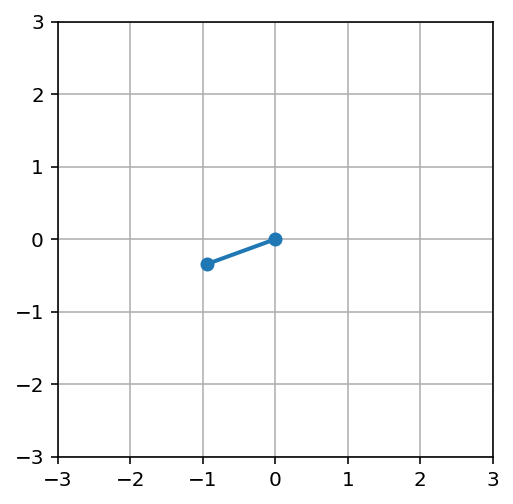

In [52]:
# Animate the solution, if you want to
ani = bot.animate(t_eval, y[:,1,4,:])
HTML(ani.to_jshtml())

In [ ]:
# LSTM
with tf.variable_scope('pi/simple_pol/'):
    lstm_model = Sequential()
    lstm_model.add(LSTM(12, input_shape =(2,1)))
    lstm_model.add(Dense(1))

    #model.add(Dense(2))
    
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Train LSTM

lstm_history = lstm_model.fit(y.reshape(50,2,-1), u.reshape(50,1,-1), epochs=500, verbose=0)
plt.plot(lstm_history.history['loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q, t=0):
        
        qc = q.copy()
        qc[0] = q[0] % (2*pi)
        
        if (qc[0] < 140 * rad) or (qc[0] > 220 * rad):
            print("hello")
            return model.predict(qc.reshape((1,2,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = 60.162
            u = -(k1 * (qc[0] - pi) + k2 * qc[1])
            
        return np.clip(u, -5, 5)     
        
    return nn_controller

In [19]:
# TODO, this is exactly the same as above, maybe should be made into a function

#bot.control = make_controller(lstm_model)

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..

num_trials = 10 # this is the number of intital conditions to try, note the total number of trials is num_trials*num_trials

min_theta = -pi/2
max_theta = pi/2

min_thdot = -5
max_thdot = 5

theta_vals = np.linspace(min_theta, max_theta, num_trials)
thdot_vals = np.linspace(min_thdot, max_thdot, num_trials)

dt = .01 # We use a variable sized integrator so this doesn't affect the accuracy of integration, only the points we use for training
t_eval = np.arange(0.0, 5, dt)

u_lstm = np.zeros((len(t_eval),num_trials, num_trials))
y_lstm = np.zeros((len(t_eval), num_trials, num_trials,2))

success_list = []
for i, theta in enumerate(theta_vals):
    for j,thdot in enumerate(thdot_vals):

        # integrate the ODE (by default this is equivalent to ode45)
        sol = integrate.solve_ivp(bot.derivs,(0,5), init_state, t_eval = t_eval)
        y[:,i,j,:] = sol.y.T
        

        # TODO figure out how to just return u the first time
        for t in range(len(t_eval)):
            u_lstm[t,i,j] = bot.control(t, y_lstm[t,i,j,:]) 

ValueError: could not broadcast input array from shape (500,2) into shape (50,2)

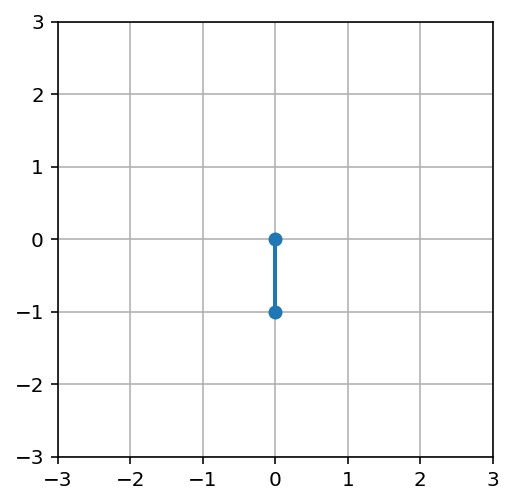

In [50]:
ani = bot.animate(t_eval,  y_lstm[:,9,1,:])
HTML(ani.to_jshtml())

In [22]:
# make list of trajectories that are actually balanced
# We stop the trajectory when it gets to within delta of [pi, 0], and then index it backwards in time
# So that t = 0 is when all trajectories are at the same point. t=1 is one step backwards etc. 

traj_list = []

for i in range(num_trials):
    for j in range(num_trials):
        # check if solution is within epsilon ball of [pi,0] , which is our target
        delta = .01
        if  (-delta + pi) < y_traj[-1,i,j,0]  < (delta + pi)   and   -delta < y_traj[-1,i,j,1]  < delta:
            #print("%d %d gives %f" % (i, j ,y_lstm[-1,i,j,0]))
            
            for t in range(0,len(y_traj[:,i,j,0])):
                if (-delta + pi) < y_traj[t,i,j,0]  < (delta + pi)   and   -delta < y_traj[t,i,j,1]  < delta:
                    traj_list.append(np.flip(y_traj[0:t,i,j,:], axis=0))
                    break
                

In [24]:
# Plot all the trajectories

%matplotlib
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_aspect('equal')
ax.grid(True, which='both')


for traj in traj_list:
    plt.plot(traj[:,0], traj[:,1],'->')

Using matplotlib backend: MacOSX


In [10]:
# Calculate thefractional dimension at each time step (or something like that anyway)
# Method described in section 11.5 of strogatz

# I think to follow strogatz faithfully we would need to look at all time points at the same time, rather than one t at a time like 
# we are currently doing

# just calculating the length of the shortest trajectory
min_t = min([x.shape[0] for x in traj_list]) 

NR_list = []
r_delta = .01
num_point_trials = 1

for i in range(min_t):
    points = [traj[i,:] for traj in traj_list]
    NR_list.append([])
    
    
    for j in range(num_point_trials):
        tmp_list = []
        r = delta**2 # length of the ball around our point. delta from above, need to start somewhere
        N = 0
        point0 = points[random.randint(0,len(traj_list) - 1)]

        while(N < len(traj_list)):
            N = 0 # the number of points enclosed in our ball
            for point in points:
                if sum((point0 - point)**2) <= r: 
                    N+=1

            NR_list[i].append((r,N))
            r += r_delta
  

In [25]:
# Calculate thefractional dimension at each time step (or something like that anyway)
# Method Katie Suggests

# just calculating the length of the shortest trajectory
min_t = min([x.shape[0] for x in traj_list]) 

NR_list = []
r_delta = .01

for i in range(min_t):
    NR_list.append([])
    
    r_min = delta**2 # Length of the ball around our point. Delta from above, need to start somewhere
    r_max = 3
    num_r = 10
    N = 0
    
    for r in np.linspace(r_min, r_max, num=num_r):
        N = 0
        points = [traj[i,:] for traj in traj_list]
        random.shuffle(points) #shuffles points in place

        while(True):
            # Is a try catch really the best way to terminate?
            # probably not but right now I don't care
            try:
                center = points.pop(0) # pop also removes point from our list
                points[:] = [x for x in points if sum((center - x)**2) < r]
                N+=1
            except IndexError:
                NR_list[i].append((N,r))
                break
        
        

In [ ]:
# Save to matlab. useful for plotting lots of trajectories, which matplotlib chokes on
import scipy.io as sio
sio.savemat('../matlab_lstm/pend1000.mat', {'data_overfit': y_lstm} )
